In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [412]:
# 加载数据
file_path = "./TrainDataset2024.xls"  # 数据文件路径
data = pd.read_excel(file_path)

# 检查数据基本信息
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 121 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(12), object(1)
memory usage: 378.2+ KB
None
       pCR (outcome)  RelapseFreeSurvival (outcome)         Age          ER  \
count     400.000000                     400.000000  400.000000  400.000000   
mean       12.697500                      56.000208   51.804674    0.547500   
std       111.107417                      27.137584   10.948522    0.498362   
min         0.000000                       0.000000   23.000000    0.000000   
25%         0.000000                      38.000000   44.516769    0.000000   
50%         0.000000                      55.000000   51.019507    1.000000   
75%         0.000000                      73.000000   60.000000    1.000000   
max       999.000000                     144.000000   79.603012    1.000000   

              PgR        HER2  TrippleNegative  ChemoGrade  Proliferation  \
count  400.0000

In [413]:
# Step 1: 缺失值处理
# 替换 999 为 NaN
data.replace(999, np.nan, inplace=True)
data['Gene'] = data['Gene'].fillna(-1)
# 查看缺失值情况
print(data.isnull().sum())

# 对于分类变量，用众数填充
categorical_features = ['ER', 'PgR','HER2', 'TrippleNegative', 'ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage', 'Gene']
for col in categorical_features:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    data[col] = imputer_cat.fit_transform(data[[col]])

ID                                                    0
pCR (outcome)                                         5
RelapseFreeSurvival (outcome)                         0
Age                                                   0
ER                                                    0
PgR                                                   1
HER2                                                  1
TrippleNegative                                       1
ChemoGrade                                            3
Proliferation                                         2
HistologyType                                         3
LNStatus                                              1
TumourStage                                           0
Gene                                                  0
original_shape_Elongation                             0
original_shape_Flatness                               0
original_shape_LeastAxisLength                        0
original_shape_MajorAxisLength                  

In [414]:
# Check imbalance 
print(f"Ratio of '1' in pCR is {(data['pCR (outcome)']==1).sum() / data['pCR (outcome)'].count()}")
# This Indicate imbalance exsists, potential optimize point

Ratio of '1' in pCR is 0.21265822784810126


In [415]:
# 对于数值变量，用中位数填充
numerical_features = [col for col in data.columns if col not in categorical_features + ['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)']]
imputer_num = SimpleImputer(strategy='median')
data[numerical_features] = imputer_num.fit_transform(data[numerical_features])

# Step 2: 异常值检测和处理
# 使用箱线图法检测异常值（示例以 Tumour Proliferation 为例）
for col in numerical_features:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # 替换异常值为边界值
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])


In [416]:
# Step 3: 数据归一化
# 选择需要归一化的列（通常是数值型特征）
scaler = StandardScaler()  # 或者使用 StandardScaler
data[numerical_features] = scaler.fit_transform(data[numerical_features])


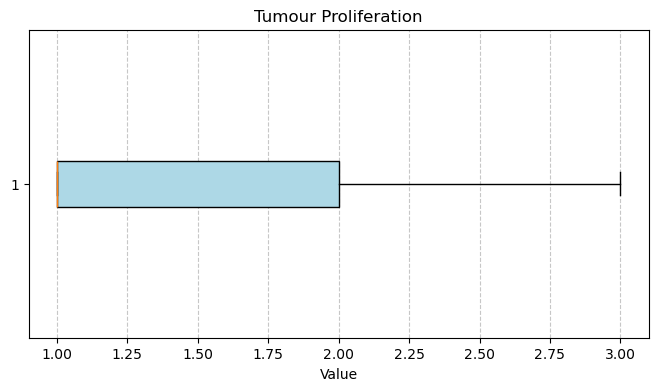

In [417]:
plt.figure(figsize=(8, 4))
plt.boxplot(data['Proliferation'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Tumour Proliferation')
plt.xlabel('Value')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

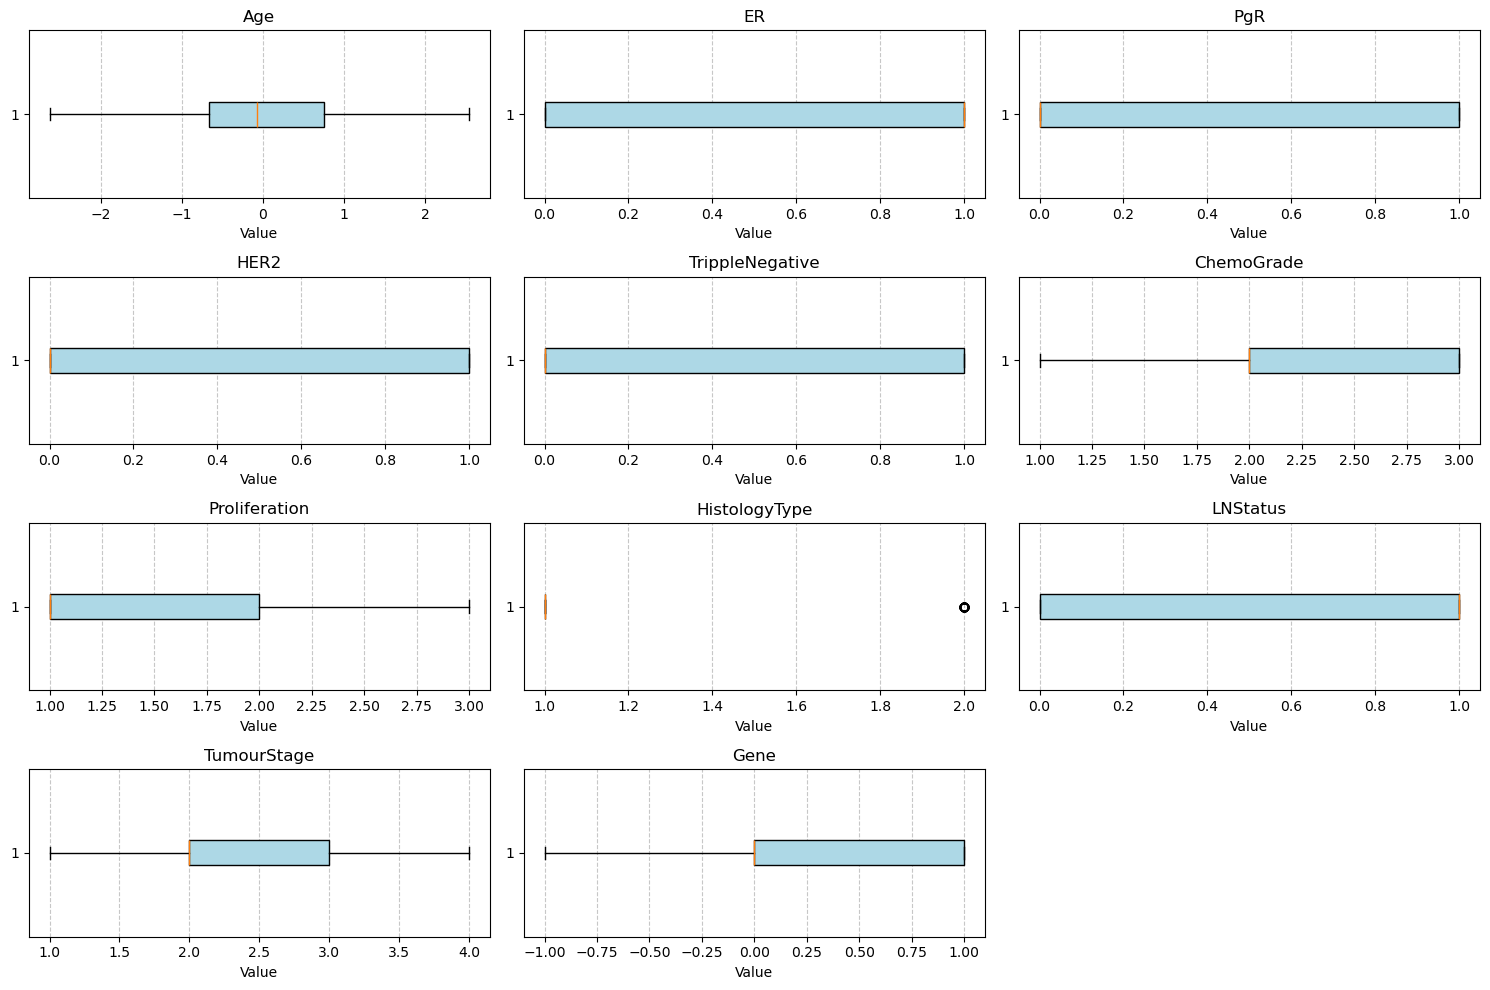

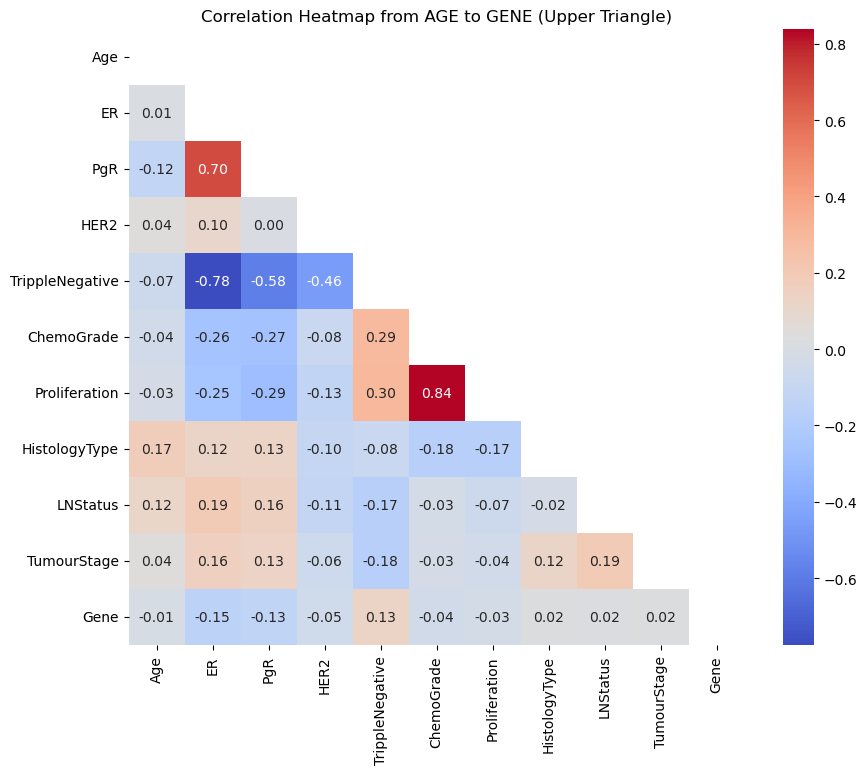

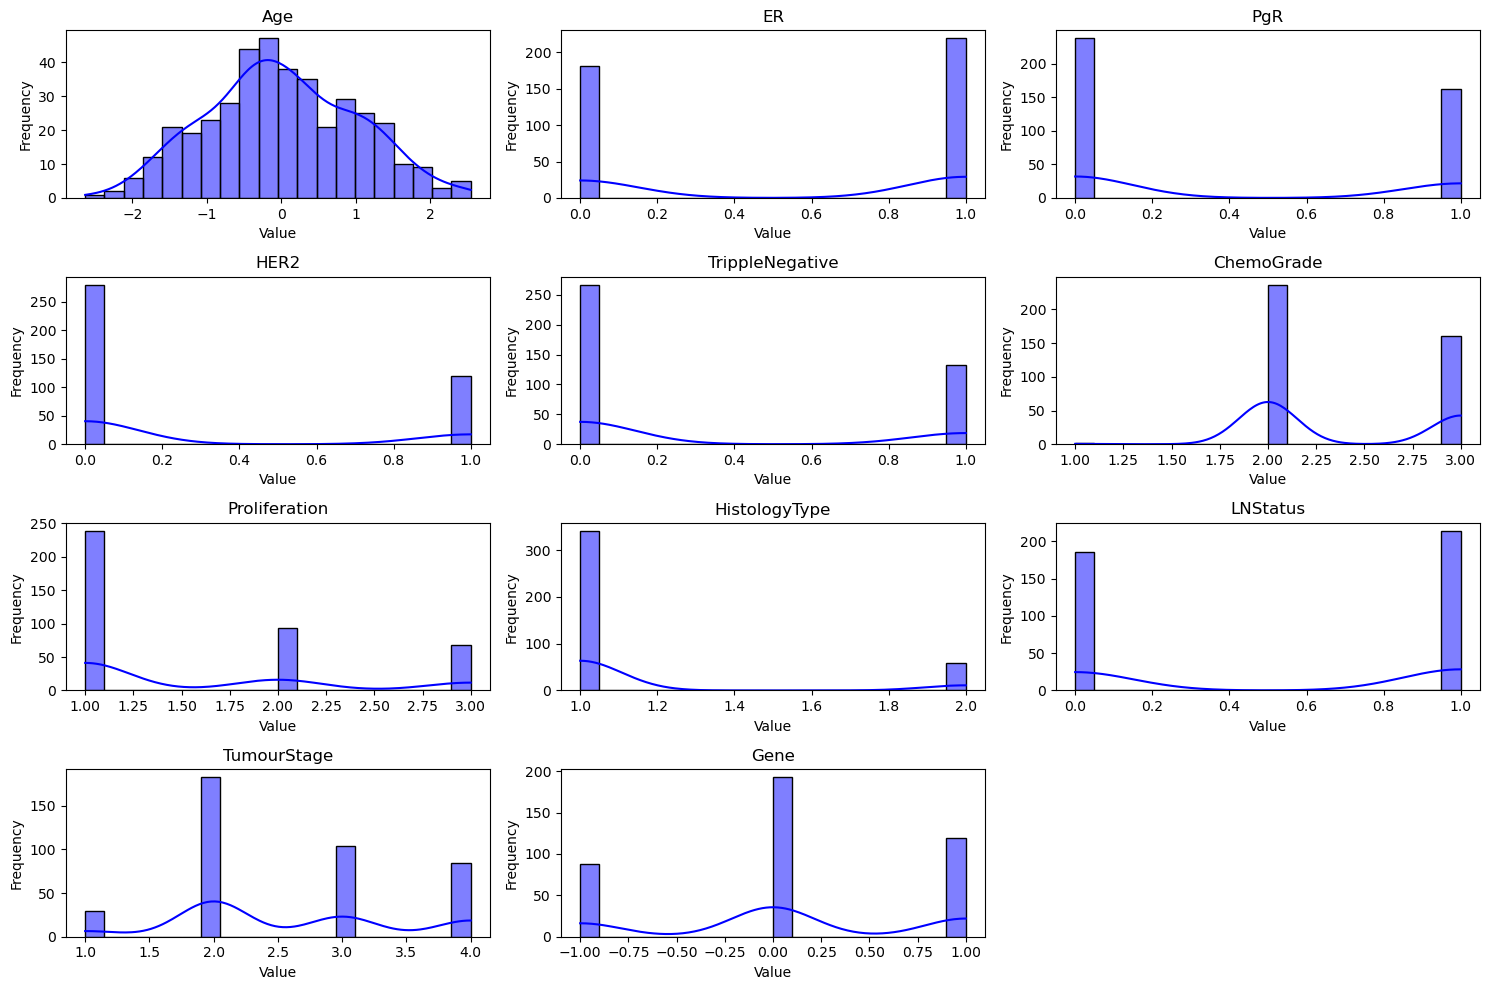

In [418]:
# 选择 AGE 到 GENE 的列
selected_columns = data.loc[:, 'Age':'Gene']

# Step 1: 绘制箱线图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    plt.boxplot(selected_columns[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(col)
    plt.xlabel('Value')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Step 2: 绘制相关性热图
# 计算相关性矩阵
corr_matrix = selected_columns.corr()

# 使用 Seaborn 绘制热成像分布图

plt.figure(figsize=(10, 8))

# 创建掩码
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 使用 Seaborn 绘制热成像分布图（仅上三角）
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.title("Correlation Heatmap from AGE to GENE (Upper Triangle)")

plt.show()

# Step 3: 绘制直方图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    sns.histplot(selected_columns[col], kde=True, color='blue', bins=20)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [419]:
# Step 4: 数据划分
# 提取特征和目标变量
X = data.drop(columns=['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)'])  # 去除 ID 和目标列
X_pCr = data[data['pCR (outcome)'].isin([0, 1])]
X_pCr = X_pCr.drop(columns=['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)']) 

# 分类任务目标
# remove when pCR is absent and pCR is target
y_pcr = data[data['pCR (outcome)'].isin([0, 1])]
y_pcr = y_pcr['pCR (outcome)']
y_rfs = data['RelapseFreeSurvival (outcome)']  # 回归任务目标

In [420]:
# 按 8:2 分层划分训练集和验证集
X_train_pcr, X_val_pcr, y_train_pcr, y_val_pcr = train_test_split(
    X_pCr, y_pcr, test_size=0.2, random_state=42, stratify=y_pcr
)
X_train_rfs, X_val_rfs, y_train_rfs, y_val_rfs = train_test_split(
    X, y_rfs, test_size=0.2, random_state=42
)


In [421]:
# SMOTE
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,SMOTENC
from imblearn.combine import SMOTETomek

#smote = SMOTETomek()
smote = SMOTENC(categorical_features = categorical_features, random_state=42)
#smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pcr, y_train_pcr)
print("Class distribution after SMOTE:", np.bincount(y_train_resampled))


Class distribution after SMOTE: [249 249]


C:\Users\22519\AppData\Local\Temp\ipykernel_92928\366441225.py:9: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print("Class distribution after SMOTE:", np.bincount(y_train_resampled))


In [422]:
# Step 5: 检查处理结果
print("训练集和验证集的大小：")
print("PCR 训练集:", X_train_resampled.shape, "验证集:", X_val_pcr.shape)
print("RFS 训练集:", X_train_rfs.shape, "验证集:", X_val_rfs.shape)

训练集和验证集的大小：
PCR 训练集: (498, 118) 验证集: (79, 118)
RFS 训练集: (320, 118) 验证集: (80, 118)


In [423]:
# pCR Baseline Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 对于SMOTE前后的性能比较

print("Before SMOTE")
# Model 0-1: LogisticRegression
lr = LogisticRegression(max_iter = 500,random_state=42)
lr.fit(X_train_pcr, y_train_pcr)
logistic_y_pred = lr.predict(X_val_pcr)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val_pcr, logistic_y_pred))

# Model 0-2: RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pcr, y_train_pcr)
random_y_pred = rf.predict(X_val_pcr)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val_pcr, random_y_pred))

print("After SMOTE")

# Model 1: LogisticRegression
lr = LogisticRegression(max_iter = 500,random_state=42)
lr.fit(X_train_resampled, y_train_resampled)
logistic_y_pred = lr.predict(X_val_pcr)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val_pcr, logistic_y_pred))

# Model 2: RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
random_y_pred = rf.predict(X_val_pcr)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val_pcr, random_y_pred))

Before SMOTE

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.90      0.84        62
         1.0       0.14      0.06      0.08        17

    accuracy                           0.72        79
   macro avg       0.46      0.48      0.46        79
weighted avg       0.64      0.72      0.67        79


Random Forest- Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88        62
         1.0       0.50      0.12      0.19        17

    accuracy                           0.78        79
   macro avg       0.65      0.54      0.53        79
weighted avg       0.74      0.78      0.73        79

After SMOTE

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80        62
         1.0       0.28      0.29      0.29        17

    accuracy              

In [424]:
from sklearn.model_selection import cross_val_score, KFold
# 调整超参数 并用随机森林分析特征重要程度
# Model 2: RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', n_estimators=75,random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
rf_y_pred = rf.predict(X_val_pcr)
print("\nRandom Forest- Classification Report:")
print(classification_report(y_val_pcr, rf_y_pred))

# Extract feature importances
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display ranked features
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(feature_importances)

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print("ROC-AUC:")
cross_val_results = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=kf,scoring="roc_auc")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())

print("\nAccuracy:")
cross_val_results = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=kf,scoring="accuracy")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Accruacy Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())



Random Forest- Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87        62
         1.0       0.43      0.18      0.25        17

    accuracy                           0.77        79
   macro avg       0.62      0.56      0.56        79
weighted avg       0.72      0.77      0.73        79

                                               Feature  Importance
10                                                Gene    0.050365
3                                                 HER2    0.032032
2                                                  PgR    0.024942
1                                                   ER    0.015830
91     original_glrlm_RunLengthNonUniformityNormalized    0.014208
39                        original_firstorder_Skewness    0.013325
83                    original_glrlm_GrayLevelVariance    0.012864
12                             original_shape_Flatness    0.012719
14                      origina

In [425]:
from sklearn.model_selection import cross_val_score, KFold

# 调整了一些超参数
# Model 1: LogisticRegression
lr = LogisticRegression(C=1.2,max_iter=500,solver='liblinear',class_weight='balanced',random_state=42)
lr.fit(X_train_resampled, y_train_resampled)
lr_y_pred = lr.predict(X_val_pcr)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val_pcr, lr_y_pred))

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print("ROC-AUC:")
cross_val_results = cross_val_score(lr, X_train_resampled, y_train_resampled, cv=kf,scoring="roc_auc")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())

print("\nAccuracy:")
cross_val_results = cross_val_score(lr, X_train_resampled, y_train_resampled, cv=kf,scoring="accuracy")
print(f'Cross-Validation Results: {cross_val_results}')
print(f'Mean Accruacy Score: {cross_val_results.mean()}')
print("Variance of model performance:", cross_val_results.var())



Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80        62
         1.0       0.28      0.29      0.29        17

    accuracy                           0.68        79
   macro avg       0.54      0.54      0.54        79
weighted avg       0.69      0.68      0.69        79

ROC-AUC:
Cross-Validation Results: [0.90625    0.87025704 0.87070707 0.85684988 0.83716161]
Mean Score: 0.8682451186948787
Variance of model performance: 0.0005101032418246809

Accuracy:
Cross-Validation Results: [0.8        0.82       0.8        0.80808081 0.80808081]
Mean Accruacy Score: 0.8072323232323232
Variance of model performance: 5.3813284358738374e-05


Threshold: 0.1, Precision: 0.28, Recall: 0.76, F1: 0.41
Threshold: 0.2, Precision: 0.29, Recall: 0.59, F1: 0.39
Threshold: 0.3, Precision: 0.36, Recall: 0.53, F1: 0.43
Threshold: 0.4, Precision: 0.33, Recall: 0.41, F1: 0.37
Threshold: 0.5, Precision: 0.28, Recall: 0.29, F1: 0.29
Threshold: 0.6, Precision: 0.29, Recall: 0.24, F1: 0.26
Threshold: 0.7, Precision: 0.22, Recall: 0.12, F1: 0.15
Threshold: 0.8, Precision: 0.17, Recall: 0.06, F1: 0.09
Threshold: 0.9, Precision: 0.25, Recall: 0.06, F1: 0.10


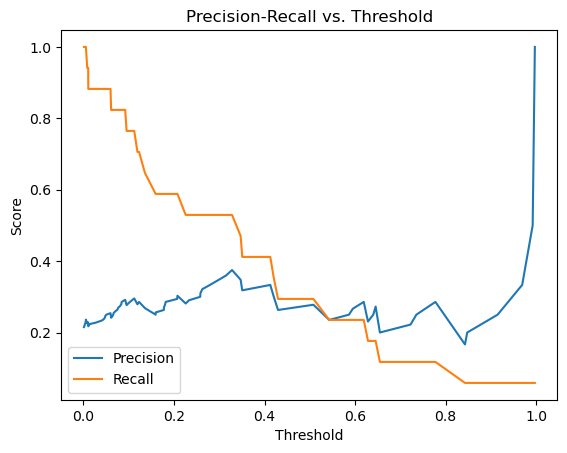

Best Threshold: 0.32828072131338887, Best F1-Score: 0.43902439024390244
Best Threshold (Youden's J): 0.32828072131338887


In [426]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 对 theroshold 进行调整可以进行precision和recall的取舍，可以根据具体需求调整
# thershold tuning
y_probs = lr.predict_proba(X_val_pcr)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)  # Convert probabilities to binary predictions
    precision = precision_score(y_val_pcr, y_pred)
    recall = recall_score(y_val_pcr, y_pred)
    f1 = f1_score(y_val_pcr, y_pred)
    print(f"Threshold: {threshold:.1f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val_pcr, y_probs)

# Plot the curve
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Precision-Recall vs. Threshold')
plt.show()

best_threshold = 0
best_f1 = 0
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_val_pcr, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")
    
from sklearn.metrics import roc_curve

# Get false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_val_pcr, y_probs)

# Compute Youden's J statistic
j_scores = tpr - fpr
best_threshold = thresholds[np.argmax(j_scores)]

print(f"Best Threshold (Youden's J): {best_threshold}")


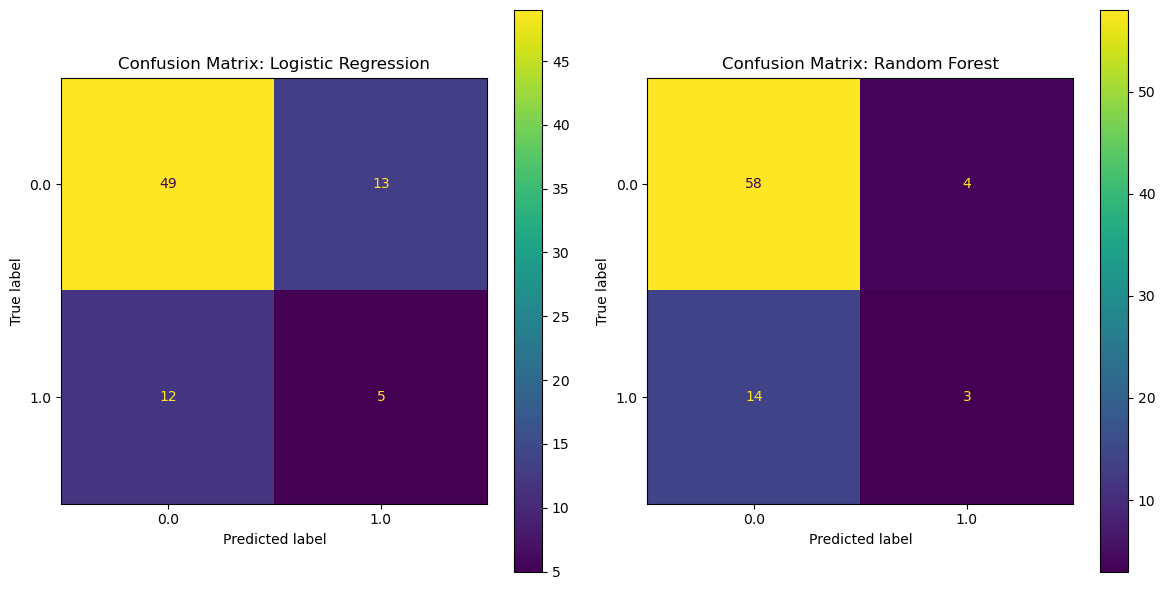

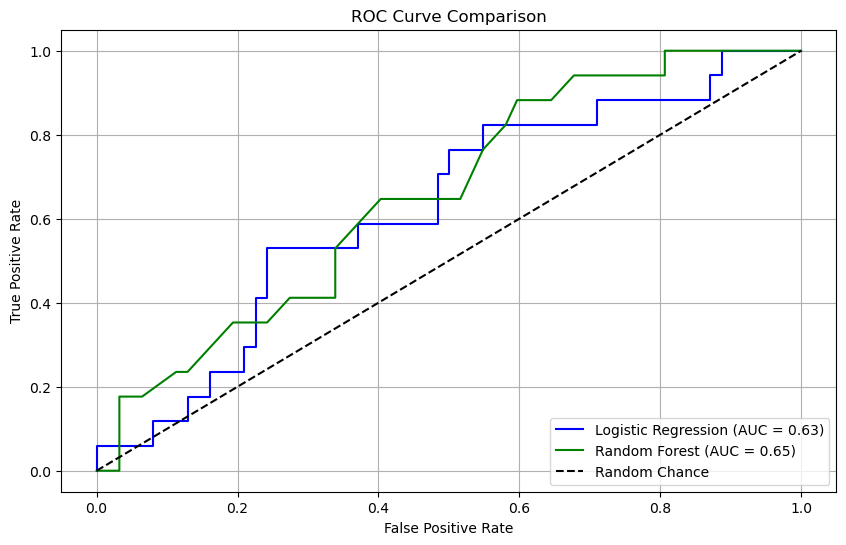

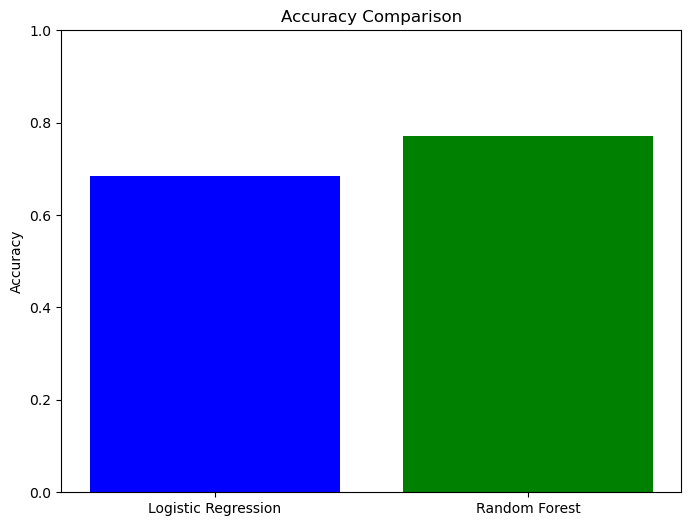

In [427]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, accuracy_score

# Step 1: Predictions and Probabilities for Logistic Regression
logistic_y_prob = lr.predict_proba(X_val_pcr)[:, 1]  # Probabilities for ROC
logistic_accuracy = accuracy_score(y_val_pcr, lr_y_pred)

# Step 2: Predictions and Probabilities for Random Forest
random_y_prob = rf.predict_proba(X_val_pcr)[:, 1]  # Probabilities for ROC
random_accuracy = accuracy_score(y_val_pcr, rf_y_pred)

# Step 3: Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay.from_predictions(y_val_pcr, lr_y_pred, ax=ax[0])
ax[0].set_title('Confusion Matrix: Logistic Regression')

ConfusionMatrixDisplay.from_predictions(y_val_pcr, rf_y_pred, ax=ax[1])
ax[1].set_title('Confusion Matrix: Random Forest')

plt.tight_layout()
plt.show()

# Step 4: ROC Curves 
# 模型越快上升性能越好
logistic_fpr, logistic_tpr, _ = roc_curve(y_val_pcr, logistic_y_prob)
random_fpr, random_tpr, _ = roc_curve(y_val_pcr, random_y_prob)

logistic_auc = auc(logistic_fpr, logistic_tpr)
random_auc = auc(random_fpr, random_tpr)

plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_auc:.2f})', color='blue')
plt.plot(random_fpr, random_tpr, label=f'Random Forest (AUC = {random_auc:.2f})', color='green')

# Diagonal for random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Plot settings
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 5: Bar Chart for Accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Logistic Regression', 'Random Forest'], [logistic_accuracy, random_accuracy], color=['blue', 'green'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


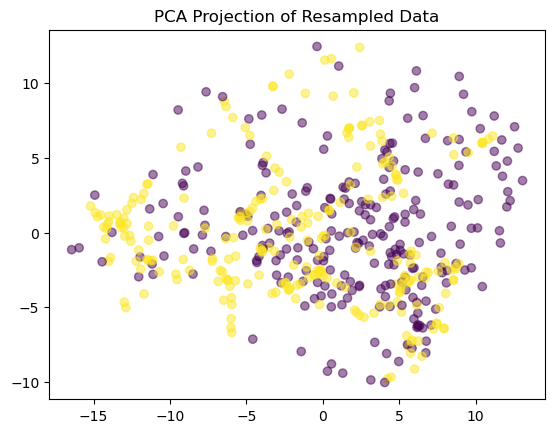

In [428]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 数据重叠严重，模型难以辨别
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_resampled, cmap='viridis', alpha=0.5)
plt.title("PCA Projection of Resampled Data")
plt.show()


In [429]:
from sklearn.metrics import roc_auc_score

# Model 1: LogisticRegression
lr = LogisticRegression(C=1.2,max_iter=500,solver='liblinear',class_weight='balanced',random_state=42)
lr.fit(X_train_resampled, y_train_resampled)
lr_y_pred = lr.predict(X_val_pcr)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val_pcr, lr_y_pred))

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Metrics
y_pred = lr.predict(X_val_pcr)
y_prob = lr.predict_proba(X_val_pcr)[:, 1]  # For ROC-AUC
accuracy = accuracy_score(y_val_pcr, y_pred)
precision = precision_score(y_val_pcr, y_pred)
recall = recall_score(y_val_pcr, y_pred)
f1 = f1_score(y_val_pcr, y_pred)
roc_auc = roc_auc_score(y_val_pcr, y_prob)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")



Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80        62
         1.0       0.28      0.29      0.29        17

    accuracy                           0.68        79
   macro avg       0.54      0.54      0.54        79
weighted avg       0.69      0.68      0.69        79

Accuracy: 0.6835
Precision: 0.2778
Recall: 0.2941
F1-Score: 0.2857
ROC-AUC: 0.6252


In [430]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np

# Function to compute bias and variance
def compute_bias_variance(model, X, y, cv=5):
    # Initialize arrays to store predictions and targets
    all_predictions = np.zeros(len(y))
    fold_predictions = []
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train the model and predict on the test fold
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Store predictions in their correct positions
        all_predictions[test_idx] = predictions
        fold_predictions.append(predictions)

    # Convert fold predictions to a numpy array
    fold_predictions = np.array([np.concatenate(fold_predictions)])

    # Compute average predictions
    avg_predictions = np.mean(fold_predictions, axis=0)

    # Compute Bias and Variance
    bias = np.mean((y - avg_predictions) ** 2)
    variance = np.mean((fold_predictions - avg_predictions) ** 2)
    return bias, variance

bias, variance = compute_bias_variance(lr, X_train_resampled, y_train_resampled, cv=5)
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")


Bias: 0.4378
Variance: 0.0000


<Axes: >

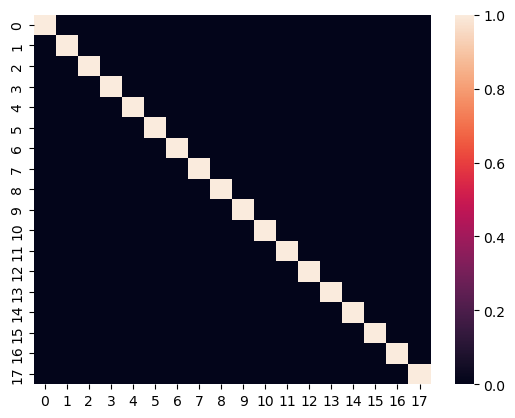

In [431]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 18)
X_train_pca = pca.fit_transform(X_train_resampled)
X_val_pca = pca.transform(X_val_pcr)
X_train_pca = pd.DataFrame(X_train_pca)
X_val_pca = pd.DataFrame(X_val_pca)

X_train_pca.head()
sns.heatmap(X_train_pca.corr())

In [432]:
# Model 1: LogisticRegression
lr = LogisticRegression(C=1.2,max_iter=500,solver='liblinear',class_weight='balanced',random_state=42)
lr.fit(X_train_pca, y_train_resampled)
lr_y_pred = lr.predict(X_val_pca)
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_val_pcr, lr_y_pred))

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Metrics
y_probs = lr.predict_proba(X_val_pca)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)
#y_pred = lr.predict(X_val_pca)
#y_prob = lr.predict_proba(X_val_pca)[:, 1]  # For ROC-AUC
accuracy = accuracy_score(y_val_pcr, y_pred)
precision = precision_score(y_val_pcr, y_pred)
recall = recall_score(y_val_pcr, y_pred)
f1 = f1_score(y_val_pcr, y_pred)
roc_auc = roc_auc_score(y_val_pcr, y_prob)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
bias, variance = compute_bias_variance(lr, X_train_resampled, y_train_resampled, cv=5)
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.81        62
         1.0       0.41      0.65      0.50        17

    accuracy                           0.72        79
   macro avg       0.65      0.69      0.65        79
weighted avg       0.78      0.72      0.74        79

Accuracy: 0.7215
Precision: 0.4074
Recall: 0.6471
F1-Score: 0.5000
ROC-AUC: 0.6252
Bias: 0.4378
Variance: 0.0000
